In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f, te, l
from sklearn.metrics import mean_squared_error
import math

In [65]:
BASEPATH = 'C:\SuryaMain\Python Projects\Chinook-Growth-Project'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")
datasets = [name for name in os.listdir(SIMULATION_BASEPATH) if name[0:4] == 'data'] 
    
def get_data(fname):
    path = os.path.join(SIMULATION_BASEPATH, fname)
    if os.path.exists(path):
        X = pd.read_csv(os.path.join(path, 'X.csv'))
        X.drop(X.columns[0], axis=1, inplace=True)
        y = pd.read_csv(os.path.join(path, 'y.csv'))
        y.drop(y.columns[0], axis=1, inplace=True)
        return [X, y]
    else: 
        print("Dataset does not exist")
        return [0,0]
        
class SimGAM:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.model = None
        
    def get_X(self):
        return self.X
    
    def get_Y(self):
        return self.y
        
    def train_lgam(self, **kwargs):
        gam = LinearGAM(**kwargs).fit(self.X, self.y)
        lams = []
        if 'lam' in kwargs.keys():
            lams = kwargs.get('lam')
        else:
            lams = np.logspace(-5,5,20)*len(self.X.columns)
        gam.gridsearch(self.X, self.y, lam=lams)
        self.model = gam
        
    def partial_dependences(self):
        pds = {}
        num_vars = X.shape[1]
        for var in range(num_vars):  # Number of variables
            sample = fill_vals(num_vars, var)
            pdep = self.model.partial_dependence(term=var, X=sample)
            pds[f'var{var}'] = pdep
        return pds
    
    def calc_aic(self):
        if self.model is not None:
            num_params = len(self.model.coef_) + 1
            aic = -2*self.model.loglikelihood(self.X,self.y) + 2*num_params
            return aic
        else: 
            print("Model Has Not Been Trained")
            return 0.0

def fill_vals(num_vars, var_idx):
    sample = np.zeros(shape=(100, num_vars))
    rand_vals = sorted(np.random.normal(0,1,100))
    for row_idx, row in enumerate(sample):
        row[var_idx] = rand_vals[row_idx]
    return sample     

(array([  1.,   0.,   0.,  11.,  30.,  80., 165., 299., 517., 644., 754.,
        812., 650., 474., 289., 162.,  65.,  34.,  12.,   1.]),
 array([-4.29083487, -3.89936968, -3.50790448, -3.11643929, -2.72497409,
        -2.3335089 , -1.9420437 , -1.55057851, -1.15911331, -0.76764812,
        -0.37618292,  0.01528227,  0.40674747,  0.79821266,  1.18967786,
         1.58114305,  1.97260825,  2.36407344,  2.75553863,  3.14700383,
         3.53846902]),
 <BarContainer object of 20 artists>)

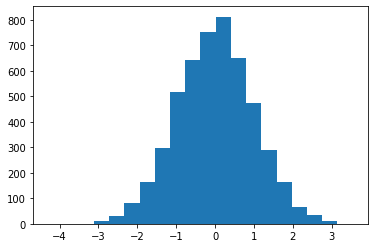

In [75]:
samples = np.random.normal(0, 1, 5000)
plt.hist(samples, bins=20)

In [90]:
class SimGAMTest(LinearGAM):
    def __init__(self, X, y, **kwargs):
        super().__init__(**kwargs)
        self.X = X
        self.y = y
        self.trained = False
        
    def get_X(self):
        return self.X
    
    def get_Y(self):
        return self.y
        
    def fit(self):
        lams = np.logspace(-5,5,20)*self.X.shape[1]
        super().fit(self.X, self.y)
        super().gridsearch(self.X, self.y, lam=lams)
        self.trained = True
        
    def partial_dependences(self):
        pds = {}
        num_vars = X.shape[1]
        for var in range(num_vars):  # Number of variables
            sample = fill_vals(num_vars, var)
            pdep = super().partial_dependence(term=var, X=sample)
            pds[f'var{var}'] = pdep
        return pds
    
    def calc_aic(self):
        if self.trained == True:
            num_params = len(super().coef_) + 1
            aic = -2*super().loglikelihood(self.X,self.y) + 2*num_params
            return aic
        else: 
            print("Model Has Not Been Trained")

In [91]:
dataset_1 = get_data('data_set_2')
X = dataset_1[0]
y = dataset_1[1]
gam = SimGAMTest(X, y, n_splines=15)
gam.fit()
pdeps = gam.partial_dependences()

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

TypeError: fit() takes 1 positional argument but 4 were given

In [ ]:
def pdp_test(model, nrows, ncols):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    titles = list(map(lambda x:f'V{x}', np.arange(1,len(X.columns)+1)))
    num_vars = model.X.shape[1]
    for i, ax in enumerate(axs):
        ##XX = model.model.generate_X_grid(term=i) 
        sample = fill_vals(num_vars, i)
        ax.plot(sample[:,i], model.model.partial_dependence(term=i, X=sample))
        ax.plot(sample[:,i], model.model.partial_dependence(term=i, X=sample, width=.95)[1], c='r', ls='--')
        ax.set_title(titles[i]);
        ax.grid(True)
        print(sample.shape)
    plt.suptitle('Partial Dependence', size=16)
    fig.tight_layout()
    plt.show()
    
def pdp(model, nrows, ncols):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    titles = list(map(lambda x:f'V{x}', np.arange(1,len(X.columns)+1)))
    rand_data = []
    for i, ax in enumerate(axs):
        XX = model.model.generate_X_grid(term=i) 
        #sample = np.random.normal(0,1,100)
        ax.plot(XX[:, i], model.model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], model.model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(titles[i]);
        ax.grid(True)
        rand_data.append(XX)
    plt.suptitle('Partial Dependence', size=16)
    fig.tight_layout()
    plt.show()
    return rand_data


In [66]:
dataset_1 = get_data('data_set_2')
X = dataset_1[0]
y = dataset_1[1]
gam = SimGAM(X, y)
gam.train_lgam(n_splines=15)
pdeps = gam.partial_dependences()

100% (20 of 20) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [ ]:
pd_variances = [np.var(pdeps[f'var{i}']) for i in range(0, gam.get_X().shape[1])]
print(f'Variable: {np.argmax(pd_variances)}')
for i in pd_variances:
    print(i)

In [ ]:
def main():
    aic_dict = {}
    for dataset in datasets[0:10]:
        dst = get_data(dataset)
        X = dst[0]
        y = dst[1]
        gam = SimGAM(X,y)
        gam.train_lgam(n_splines=15)
        aic = gam.calc_aic()
        aic_dict[dataset] = aic
    return aic_dict



In [10]:
aics = main()

{'data_set_1': 224.96677796285633,
 'data_set_10': -203.52783008046083,
 'data_set_100': -371.65823665439086,
 'data_set_101': -210.23879580893157,
 'data_set_102': 346.11310539521145,
 'data_set_103': -51.97903947269032,
 'data_set_104': 94.2971310102175,
 'data_set_105': -364.64452260351766,
 'data_set_107': -121.4978938683551,
 'data_set_108': 400.60365465828426}